In [1]:
## IMPORTING NECESSARY LIBRARIES

import pandas as pd
import numpy as np
import re
import nltk
import random
from nltk.corpus import stopwords, wordnet
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Download stopwords if not available
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lagnikadagur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lagnikadagur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('/Users/lagnikadagur/Downloads/amazon.csv')

In [4]:
print(data.columns)

Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')


In [5]:
# Select relevant columns

reviews = data[['product_id', 'review_content', 'rating', 'discounted_price', 'actual_price', 'discount_percentage', 'rating_count']]
reviews.dropna(inplace=True)  # Drop missing values

/var/folders/h8/dcrby8fs53d64l20ljxr2p900000gn/T/ipykernel_5390/3384234460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews.dropna(inplace=True)  # Drop missing values


In [6]:
## TEXT PREPROCESSING FUNCTION

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply preprocessing
reviews['cleaned_review'] = reviews['review_content'].apply(preprocess_text)

/var/folders/h8/dcrby8fs53d64l20ljxr2p900000gn/T/ipykernel_5390/3577442632.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['cleaned_review'] = reviews['review_content'].apply(preprocess_text)


In [9]:
# DATA AUGMENTATION (Generate Synthetic Reviews)
def synonym_replacement(text, n=2):
    # Ensure the text is a string
    if not isinstance(text, str):
        text = str(text)
        
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word_idx = random.randint(0, len(words) - 1)
        synonyms = wordnet.synsets(words[word_idx])
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name().replace("_", " ")
            new_words[word_idx] = synonym
    return ' '.join(new_words)

# Generate new reviews per product
augmented_reviews = []
for _, row in reviews.iterrows():
    for _ in range(5):  # Generate 5 additional synthetic reviews per original review
        new_review = synonym_replacement(row['cleaned_review'])  # Using the cleaned_review column
        augmented_reviews.append([row['product_id'], new_review, row['rating'], row['discounted_price'],
                                  row['actual_price'], row['discount_percentage'], row['rating_count']])

# Convert to DataFrame for augmented reviews
augmented_df = pd.DataFrame(augmented_reviews, columns=['product_id', 'cleaned_review', 'rating', 'discounted_price',
                                                        'actual_price', 'discount_percentage', 'rating_count'])

# Concatenate the augmented reviews with the original reviews
reviews = pd.concat([reviews[['product_id', 'review_content', 'rating', 'discounted_price', 'actual_price',
                              'discount_percentage', 'rating_count']], augmented_df], ignore_index=True)

# Remove invalid values (e.g., '|') from the 'rating' column
reviews = reviews[reviews['rating'].str.match(r'^\d+(\.\d+)?$', na=False)]

# Convert the 'rating' column to numeric
reviews['rating'] = pd.to_numeric(reviews['rating'])

In [11]:
print(reviews.columns)

Index(['product_id', 'review_content', 'rating', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating_count',
       'cleaned_review'],
      dtype='object')


In [12]:
## SENTIMENT LABELLING FUNCTION

def label_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return 2  # Neutral

reviews['sentiment'] = reviews['rating'].apply(label_sentiment)
reviews = reviews[reviews['sentiment'] != 2]  # Exclude neutral reviews

In [16]:
## TOKENIZATION & SEQUENCE PADDING
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(reviews['cleaned_review'])
sequences = tokenizer.texts_to_sequences(reviews['cleaned_review'])
max_len = 100
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Extract labels
labels = np.array(reviews['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [17]:
## LOAD PRE-TRAINED WORD EMBEDDINGS (GloVe)

embedding_index = {}
with open('/Users/lagnikadagur/Downloads/glove.6B/glove.6B.100d.txt', 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

word_index = tokenizer.word_index
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [18]:
## BUILDING LSTM SENTIMENT MODEL

model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop])

Epoch 1/10


/Users/lagnikadagur/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


800/800 ━━━━━━━━━━━━━━━━━━━━ 91s 110ms/step - accuracy: 0.9918 - loss: 0.0512 - val_accuracy: 0.9998 - val_loss: 0.0025
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 93s 117ms/step - accuracy: 0.9998 - loss: 0.0022 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 92s 115ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 92s 114ms/step - accuracy: 0.9998 - loss: 0.0018 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 90s 112ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 90s 112ms/step - accuracy: 0.9999 - loss: 0.0015 - val

In [19]:
## SENTIMENT PREDICTION FOR FULL DATASET

def predict_sentiment(text):
    cleaned_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
    prediction = model.predict(padded_sequence)[0][0]
    return 'Positive' if prediction >= 0.5 else 'Negative'

reviews['predicted_sentiment'] = reviews['cleaned_review'].apply(predict_sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

In [20]:
print(reviews.columns)

Index(['product_id', 'review_content', 'rating', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating_count', 'cleaned_review',
       'sentiment', 'predicted_sentiment'],
      dtype='object')


In [27]:
from sklearn.impute import SimpleImputer

## DEMAND PREDICTION - FEATURE ENGINEERING

# Ensure 'rating_count' is numeric (remove commas and convert to float)
reviews['rating_count'] = reviews['rating_count'].astype(str).str.replace(',', '', regex=True).astype(float)

# Normalize rating count
scaler = MinMaxScaler()
reviews['normalized_rating_count'] = scaler.fit_transform(reviews[['rating_count']])

# Price calculations (remove currency symbols and commas)
reviews['actual_price'] = reviews['actual_price'].astype(str).replace({'₹': '', r'\$': '', ',': ''}, regex=True).astype(float)
reviews['discounted_price'] = reviews['discounted_price'].astype(str).replace({'₹': '', r'\$': '', ',': ''}, regex=True).astype(float)

# Convert discount percentage to numeric
reviews['discount_percentage'] = pd.to_numeric(reviews['discount_percentage'], errors='coerce')

# Calculate price difference and discount ratio
reviews['price_diff'] = reviews['actual_price'] - reviews['discounted_price']
reviews['price_discount_ratio'] = reviews['discount_percentage'] / 100

# Ensure 'cleaned_review' exists before applying len()
if 'cleaned_review' in reviews.columns:
    reviews['review_length'] = reviews['cleaned_review'].astype(str).apply(len)
else:
    reviews['review_length'] = 0  # Default to 0 if column is missing

# Define feature columns
features = ['normalized_rating_count', 'price_diff', 'price_discount_ratio', 'rating', 'review_length']

# Ensure all feature columns exist and have at least one non-NaN value
existing_features = [col for col in features if col in reviews.columns and reviews[col].notna().sum() > 0]

# Subset the DataFrame with valid features
X = reviews[existing_features].copy()

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame with correct column names
X = pd.DataFrame(X_imputed, columns=existing_features, index=reviews.index)

# Ensure predicted_sentiment is correctly formatted
reviews['predicted_sentiment'] = reviews['predicted_sentiment'].astype(str)

# Define target variable (demand prediction based on sentiment)
y = (reviews['predicted_sentiment'] == 'Positive') * reviews['normalized_rating_count'] * 100

# Drop NaN values from y
y = y.dropna()

# Align X with y
X = X.loc[y.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict demand
reviews.loc[y.index, 'predicted_demand'] = model.predict(X)

# Display results
print(reviews[['product_id', 'predicted_demand']].head())


   product_id  predicted_demand
0  B07JW9H4J1          5.683524
1  B098NS6PVG         10.303276
3  B08HDJ86NZ         22.100096
4  B08CF3B7N1          3.958817
6  B08WRWPM22          3.556682


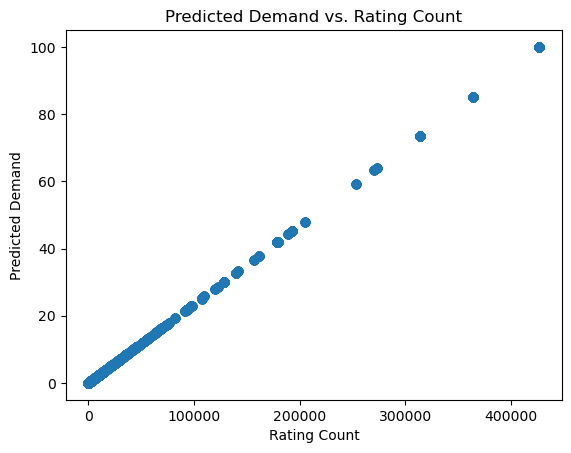

In [28]:
# Ensure proper alignment of 'rating_count' and 'predicted_demand'
plt.scatter(reviews.loc[y.index, 'rating_count'], reviews.loc[y.index, 'predicted_demand'])
plt.xlabel('Rating Count')
plt.ylabel('Predicted Demand')
plt.title('Predicted Demand vs. Rating Count')
plt.show()

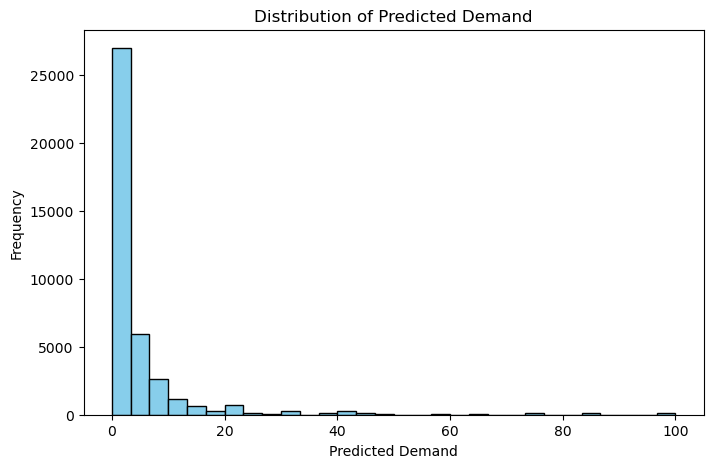

In [29]:
## HISTOGRAM

plt.figure(figsize=(8, 5))
plt.hist(reviews['predicted_demand'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Demand')
plt.show()

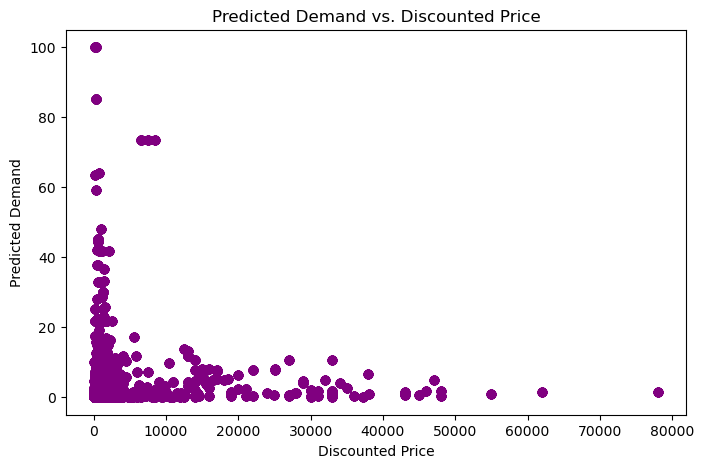

In [31]:
## SCATTER PLOT

plt.figure(figsize=(8, 5))
plt.scatter(reviews['discounted_price'], reviews['predicted_demand'], color='purple', alpha=0.5)
plt.xlabel('Discounted Price')
plt.ylabel('Predicted Demand')
plt.title('Predicted Demand vs. Discounted Price')
plt.show()